In [ ]:
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
class_to_idx = {cls: i for i, cls in enumerate(VOC_CLASSES)}
NUM_CLASSES = len(VOC_CLASSES)

In [ ]:
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class VOCMultiLabelDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None):
        self.voc = VOCDetection(root=root, year='2012', image_set=image_set, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        image, target = self.voc[idx]
        objects = target['annotation']['object']
        labels = torch.zeros(NUM_CLASSES)

        if isinstance(objects, dict):
            objects = [objects]

        for obj in objects:
            cls = obj['name']
            if cls in class_to_idx:
                labels[class_to_idx[cls]] = 1.0

        if self.transform:
            image = self.transform(image)

        return image, labels


In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_dataset = VOCMultiLabelDataset(root="/content", image_set="train", transform=transform)
val_dataset = VOCMultiLabelDataset(root="/content", image_set="val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


100%|██████████| 2.00G/2.00G [02:01<00:00, 16.5MB/s]


# CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(NUM_CLASSES).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(5):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2470
Epoch 2, Loss: 0.2012
Epoch 3, Loss: 0.1638
Epoch 4, Loss: 0.1210
Epoch 5, Loss: 0.0796


In [ ]:
import torch

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)


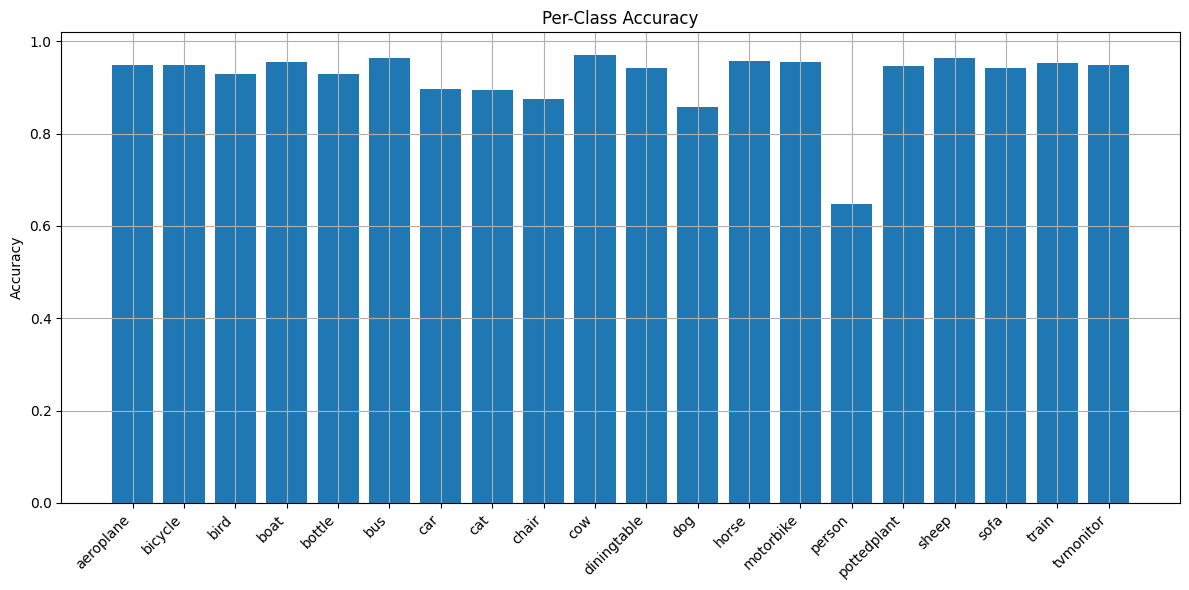

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

correct_per_class = (all_preds == all_labels).sum(dim=0)
total_per_class = all_labels.shape[0]
accuracy_per_class = correct_per_class / total_per_class

plt.figure(figsize=(12, 6))
plt.bar(VOC_CLASSES, accuracy_per_class.numpy())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


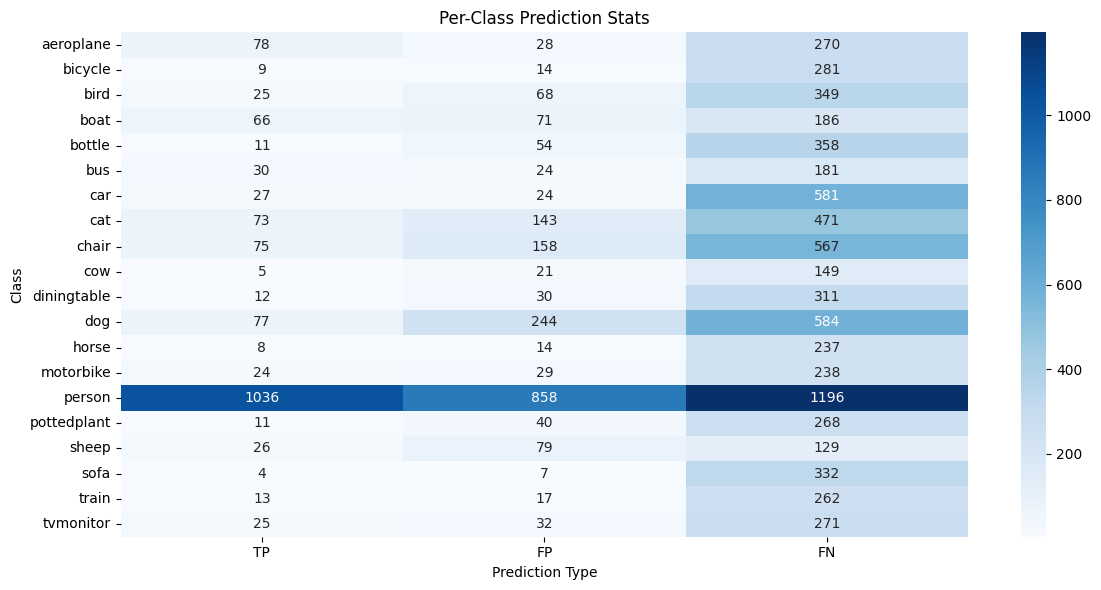

In [ ]:
import seaborn as sns

TP = ((all_preds == 1) & (all_labels == 1)).sum(dim=0)
FP = ((all_preds == 1) & (all_labels == 0)).sum(dim=0)
FN = ((all_preds == 0) & (all_labels == 1)).sum(dim=0)

conf_matrix = torch.stack([TP, FP, FN], dim=1).numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["TP", "FP", "FN"], yticklabels=VOC_CLASSES, cmap="Blues")
plt.title("Per-Class Prediction Stats")
plt.xlabel("Prediction Type")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

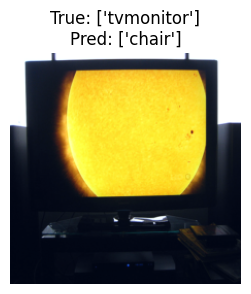

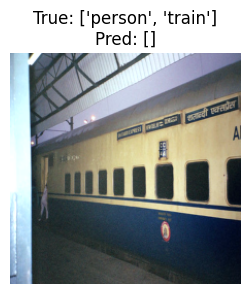

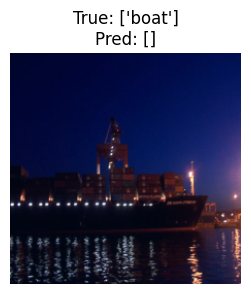

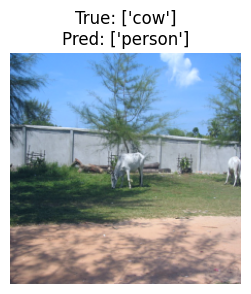

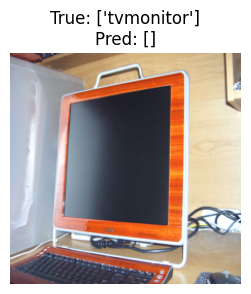

In [ ]:
from matplotlib import pyplot as plt

model.eval()
classes = VOC_CLASSES

def show_preds(n=5):
    count = 0
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        for i in range(len(images)):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img * 0.229 + 0.485)
            img = np.clip(img, 0, 1)

            true = [classes[j] for j in range(NUM_CLASSES) if labels[i][j] == 1]
            pred = [classes[j] for j in range(NUM_CLASSES) if preds[i][j] == 1]

            plt.figure(figsize=(5, 3))
            plt.imshow(img)
            plt.title(f"True: {true}\nPred: {pred}")
            plt.axis("off")
            plt.show()

            count += 1
            if count >= n:
                return

show_preds(5)


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))
        preds = outputs > 0.5
        correct += ((preds == labels.bool()).sum().item())
        total += labels.numel()

print(f"Validation accuracy (per label): {correct/total:.4f}")

Validation accuracy (per label): 0.9212


### High accuracy but low F1 score due to class imbalance (negative classes are significantly more prevalent than positive classes in each label)

# Cropped

In [ ]:
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import crop
from PIL import Image
import os
import torch
import torchvision.transforms as T

SAVE_DIR = "/content/cropped_voc"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f"{SAVE_DIR}/train", exist_ok=True)
os.makedirs(f"{SAVE_DIR}/val", exist_ok=True)

train_voc = VOCDetection(root='/content/train', year='2012', image_set='train', download=True)
val_voc = VOCDetection(root='/content/val', year='2012', image_set='val', download=True)


100%|██████████| 2.00G/2.00G [02:14<00:00, 14.9MB/s]


In [ ]:
import uuid
import csv

class_to_idx = {cls: i for i, cls in enumerate(VOC_CLASSES)}

transform = T.Resize((224, 224))

def crop_and_save_objects(voc_dataset, split_name):
    out_root = os.path.join(SAVE_DIR, split_name)

    for idx in range(len(voc_dataset)):
        image, target = voc_dataset[idx]
        objects = target['annotation']['object']
        if isinstance(objects, dict):
            objects = [objects]

        for obj in objects:
            cls_name = obj['name']
            if cls_name not in VOC_CLASSES:
                continue

            bbox = obj['bndbox']
            xmin = int(float(bbox['xmin']))
            ymin = int(float(bbox['ymin']))
            xmax = int(float(bbox['xmax']))
            ymax = int(float(bbox['ymax']))

            crop_img = image.crop((xmin, ymin, xmax, ymax))
            crop_img = transform(crop_img)

            class_dir = os.path.join(out_root, cls_name)
            os.makedirs(class_dir, exist_ok=True)

            img_name = f"{uuid.uuid4().hex}.jpg"
            crop_img.save(os.path.join(class_dir, img_name))


In [ ]:
crop_and_save_objects(train_voc, "train")
crop_and_save_objects(val_voc, "val")

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root="/content/cropped_voc/train", transform=img_transform)
val_dataset   = ImageFolder(root="/content/cropped_voc/val", transform=img_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import xml.etree.ElementTree as ET

output_dir = "./cropped"
os.makedirs(output_dir, exist_ok=True)
img_dir = os.path.join('/content/VOCdevkit/VOC2012', "JPEGImages")
ann_dir = os.path.join('/content/VOCdevkit/VOC2012', "Annotations")


def extract_crops_from_voc(image_set="train", resize=(224,224), max_per_class=None):
    file_list = os.path.join('/content/VOCdevkit/VOC2012', "ImageSets", "Segmentation", f"{image_set}.txt")
    with open(file_list, "r") as f:
        image_ids = [line.strip() for line in f if line.strip()]
    counter = {cls: 0 for cls in VOC_CLASSES}
    for image_id in image_ids:
        img_path = os.path.join(img_dir, f"{image_id}.jpg")
        ann_path = os.path.join(ann_dir, f"{image_id}.xml")
        if not os.path.exists(img_path) or not os.path.exists(ann_path):
            continue
        try:
            image = Image.open(img_path).convert("RGB")
            tree = ET.parse(ann_path)
            root_xml = tree.getroot()
        except Exception as e:
            print(f"Error processing {image_id}: {e}")
            continue
        for obj in root_xml.findall("object"):
            cls_name = obj.find("name").text.lower().strip()
            if cls_name not in VOC_CLASSES:
                continue
            if max_per_class is not None and counter[cls_name] >= max_per_class:
                continue
            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))
            if xmax - xmin < 16 or ymax - ymin < 16:
                continue
            crop = image.crop((xmin, ymin, xmax, ymax))
            crop = crop.resize(resize)
            cls_dir = os.path.join(output_dir, cls_name)
            os.makedirs(cls_dir, exist_ok=True)
            crop_path = os.path.join(cls_dir, f"{image_id}_{counter[cls_name]:04d}.jpg")
            if os.path.exists(crop_path):
                print(f"File exists, skipping: {crop_path}")
                continue
            crop.save(crop_path)
            counter[cls_name] += 1
    print(f"Crops for '{image_set}' saved in: {output_dir}")
    for cls in VOC_CLASSES:
        print(f"{cls:12s}: {counter[cls]} images")


extract_crops_from_voc("train", resize=(224,224))
extract_crops_from_voc("val", resize=(224,224))

Crops for 'train' saved in: ./cropped
aeroplane   : 104 images
bicycle     : 90 images
bird        : 133 images
boat        : 118 images
bottle      : 163 images
bus         : 118 images
car         : 188 images
cat         : 154 images
chair       : 302 images
cow         : 145 images
diningtable : 86 images
dog         : 149 images
horse       : 100 images
motorbike   : 101 images
person      : 812 images
pottedplant : 148 images
sheep       : 149 images
sofa        : 103 images
train       : 96 images
tvmonitor   : 101 images
Crops for 'val' saved in: ./cropped
aeroplane   : 110 images
bicycle     : 101 images
bird        : 137 images
boat        : 104 images
bottle      : 146 images
bus         : 113 images
car         : 214 images
cat         : 132 images
chair       : 245 images
cow         : 132 images
diningtable : 82 images
dog         : 150 images
horse       : 104 images
motorbike   : 103 images
person      : 808 images
pottedplant : 164 images
sheep       : 137 images
sofa 

In [ ]:
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="./cropped", transform=transform)
class_names = dataset.classes
labels = np.array([y for _, y in dataset])
print(f"Total images: {len(dataset)}")
print("Class names:", class_names)

train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    np.arange(len(labels)), labels,
    test_size=0.36,
    stratify=labels,
    random_state=42
)

val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=20/36,
    stratify=temp_labels,
    random_state=42
)
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Total images: 6638
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Train: 4248, Val: 1062, Test: 1328


In [ ]:
import cv2
import numpy as np
from PIL import Image
import os
from tqdm import tqdm


def segment_foreground_grabcut(input_dir="./cropped", output_dir="./segmented"):
    os.makedirs(output_dir, exist_ok=True)

    for cls_name in os.listdir(input_dir):
        cls_input_dir = os.path.join(input_dir, cls_name)
        cls_output_dir = os.path.join(output_dir, cls_name)
        os.makedirs(cls_output_dir, exist_ok=True)

        for img_name in tqdm(os.listdir(cls_input_dir), desc=f"Segmenting {cls_name}"):
            input_path = os.path.join(cls_input_dir, img_name)
            output_path = os.path.join(cls_output_dir, img_name)
            if os.path.exists(output_path):
                continue

            try:
                img = cv2.imread(input_path)
                if img is None:
                    continue
                mask = np.zeros(img.shape[:2], np.uint8)

                # GrabCut setup
                bgdModel = np.zeros((1, 65), np.float64)
                fgdModel = np.zeros((1, 65), np.float64)

                height, width = img.shape[:2]
                rect = (5, 5, width - 10, height - 10)  # crop a bit from borders

                # Apply GrabCut
                cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

                # Create binary mask
                mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
                segmented = img * mask2[:, :, np.newaxis]

                # Save
                cv2.imwrite(output_path, segmented)
            except Exception as e:
                print(f"Failed {img_name}: {e}")


In [ ]:
segment_foreground_grabcut(input_dir="./cropped", output_dir="./segmented")

Segmenting horse: 100%|██████████| 204/204 [02:30<00:00,  1.36it/s]


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='/content/drive/MyDrive/segmented_backup_deepLab_v3', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [10]:
!ls '/content/drive/MyDrive/segmented_backup_deepLab_v3'

aeroplane  boat    car	  cow	       horse	  pottedplant  train
bicycle    bottle  cat	  diningtable  motorbike  sheep        tvmonitor
bird	   bus	   chair  dog	       person	  sofa


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = deeplabv3_resnet101(pretrained=True).eval().to(device)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 115MB/s]


In [ ]:
def segment_with_deeplabv3(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for cls in os.listdir(input_dir):
        in_cls_dir = os.path.join(input_dir, cls)
        out_cls_dir = os.path.join(output_dir, cls)
        os.makedirs(out_cls_dir, exist_ok=True)

        for fname in tqdm(os.listdir(in_cls_dir), desc=f"Segmenting {cls}"):
            in_path = os.path.join(in_cls_dir, fname)
            out_path = os.path.join(out_cls_dir, fname)

            if os.path.exists(out_path):
                continue

            try:
                image = Image.open(in_path).convert("RGB")
                input_tensor = transform(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(input_tensor)["out"][0]
                    output_predictions = output.argmax(0).cpu().numpy()

                mask = output_predictions != 0
                mask = mask.astype(np.uint8) * 255

                img_np = np.array(image.resize((224, 224)))
                segmented = img_np.copy()
                segmented[mask == 0] = 0

                Image.fromarray(segmented).save(out_path)
            except Exception as e:
                print(f"Failed on {in_path}: {e}")


In [ ]:
segment_with_deeplabv3("./cropped", "./segmented_deepLab_v3")


Segmenting horse: 100%|██████████| 204/204 [00:09<00:00, 22.33it/s]


In [ ]:
import shutil

src = '/content/segmented_deepLab_v3'
dst = '/content/drive/MyDrive/segmented_backup_deepLab_v3'

shutil.copytree(src, dst)


'/content/drive/MyDrive/segmented_backup_deepLab_v3'

In [ ]:
!ls '/content/drive/MyDrive/segmented_backup_deepLab_v3'

aeroplane  boat    car	  cow	       horse	  pottedplant  train
bicycle    bottle  cat	  diningtable  motorbike  sheep        tvmonitor
bird	   bus	   chair  dog	       person	  sofa


In [ ]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
cropped_dataset = ImageFolder(root="./segmented_deepLab_v3", transform=transform)
class_names = cropped_dataset.classes

print(f"Total images in cropped dataset: {len(cropped_dataset)}")
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)

Total images in cropped dataset: 6638
Number of classes: 20
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


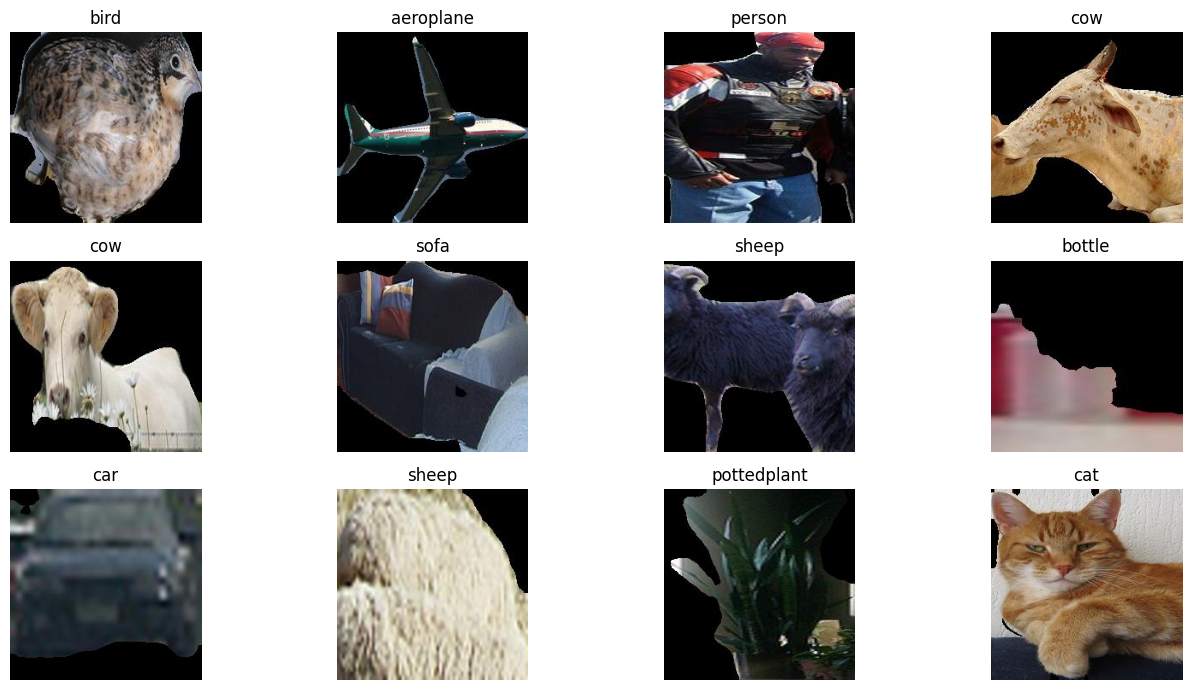

In [ ]:


transform = transforms.Compose([
    transforms.ToTensor(),  # (Don't normalize for visualization)
])
dataset = ImageFolder(root="./segmented_deepLab_v3", transform=transform)

# Mapping: label index -> class name
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Plot 12 random samples
plt.figure(figsize=(14,7))
for i in range(12):
    idx = np.random.randint(0, len(dataset))
    img, label = dataset[idx]
    # Convert tensor image to numpy
    img = img.numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)  # Safety
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(idx_to_class[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 112x112x32
        x = self.pool(F.relu(self.conv2(x)))   # 56x56x64
        x = self.pool(F.relu(self.conv3(x)))   # 28x28x128
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN(num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    return_best=True,
    save_best_path=None
):
    model = model.to(device)
    best_acc = 0
    best_model_wts = None
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_loss_epoch = train_loss / train_total
        train_acc_epoch = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss_epoch = val_loss / val_total
        val_acc_epoch = val_correct / val_total

        history['train_loss'].append(train_loss_epoch)
        history['val_loss'].append(val_loss_epoch)
        history['train_acc'].append(train_acc_epoch)
        history['val_acc'].append(val_acc_epoch)

        # Save best model by val acc
        if val_acc_epoch > best_acc:
            best_acc = val_acc_epoch
            if return_best:
                best_model_wts = model.state_dict()
            if save_best_path:
                # Save checkpoint (avoid overwrite by adding epoch/acc if needed)
                torch.save(model.state_dict(), save_best_path)

        if scheduler is not None:
            scheduler.step(val_loss_epoch)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss_epoch:.4f} Acc: {train_acc_epoch:.4f} | "
              f"Val Loss: {val_loss_epoch:.4f} Acc: {val_acc_epoch:.4f}")

    # Load best weights
    if return_best and best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="./segmented_deepLab_v3", transform=transform)
class_names = dataset.classes
labels = np.array([y for _, y in dataset])
print(f"Total images: {len(dataset)}")
print("Class names:", class_names)

train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    np.arange(len(labels)), labels,
    test_size=0.36,
    stratify=labels,
    random_state=42
)

val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=20/36,
    stratify=temp_labels,
    random_state=42
)
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


Total images: 6638
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Train: 4248, Val: 1062, Test: 1328


In [ ]:
from torch.utils.data import DataLoader, Subset

batch_size = 32
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    return_best=True,
    save_best_path="simpleCNN_segmented.pth"
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 | Train Loss: 2.7714 Acc: 0.2486 | Val Loss: 2.5634 Acc: 0.2674


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10 | Train Loss: 2.3037 Acc: 0.3213 | Val Loss: 2.2022 Acc: 0.3531


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/10 | Train Loss: 1.7262 Acc: 0.4708 | Val Loss: 2.0772 Acc: 0.3992


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/10 | Train Loss: 0.8748 Acc: 0.7354 | Val Loss: 2.6262 Acc: 0.3409


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/10 | Train Loss: 0.3883 Acc: 0.8806 | Val Loss: 3.8161 Acc: 0.3465


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/10 | Train Loss: 0.2501 Acc: 0.9268 | Val Loss: 4.4453 Acc: 0.3597


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/10 | Train Loss: 0.2016 Acc: 0.9393 | Val Loss: 4.6360 Acc: 0.3559


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/10 | Train Loss: 0.1879 Acc: 0.9414 | Val Loss: 5.7472 Acc: 0.3446


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/10 | Train Loss: 0.1701 Acc: 0.9477 | Val Loss: 6.1692 Acc: 0.3588


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/10 | Train Loss: 0.2063 Acc: 0.9409 | Val Loss: 5.5454 Acc: 0.3333


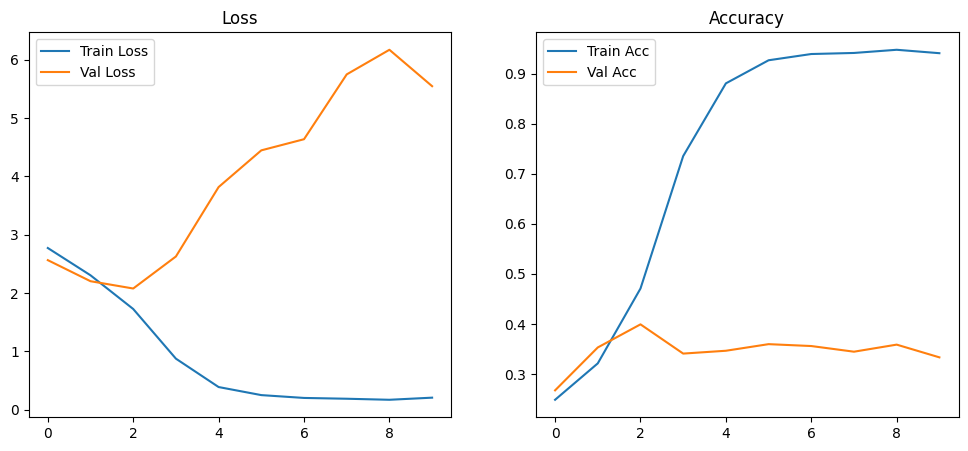

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

plot_history(history)


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {acc:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


Test accuracy: 0.3373
              precision    recall  f1-score   support

   aeroplane       0.39      0.40      0.39        43
     bicycle       0.50      0.47      0.49        38
        bird       0.21      0.09      0.13        54
        boat       0.22      0.23      0.22        44
      bottle       0.35      0.11      0.17        62
         bus       0.36      0.50      0.42        46
         car       0.39      0.27      0.32        81
         cat       0.16      0.16      0.16        57
       chair       0.16      0.19      0.17       109
         cow       0.26      0.25      0.25        56
 diningtable       0.00      0.00      0.00        34
         dog       0.21      0.12      0.15        60
       horse       0.12      0.12      0.12        41
   motorbike       0.30      0.44      0.36        41
      person       0.55      0.65      0.60       324
 pottedplant       0.21      0.39      0.28        62
       sheep       0.39      0.23      0.29        57
     

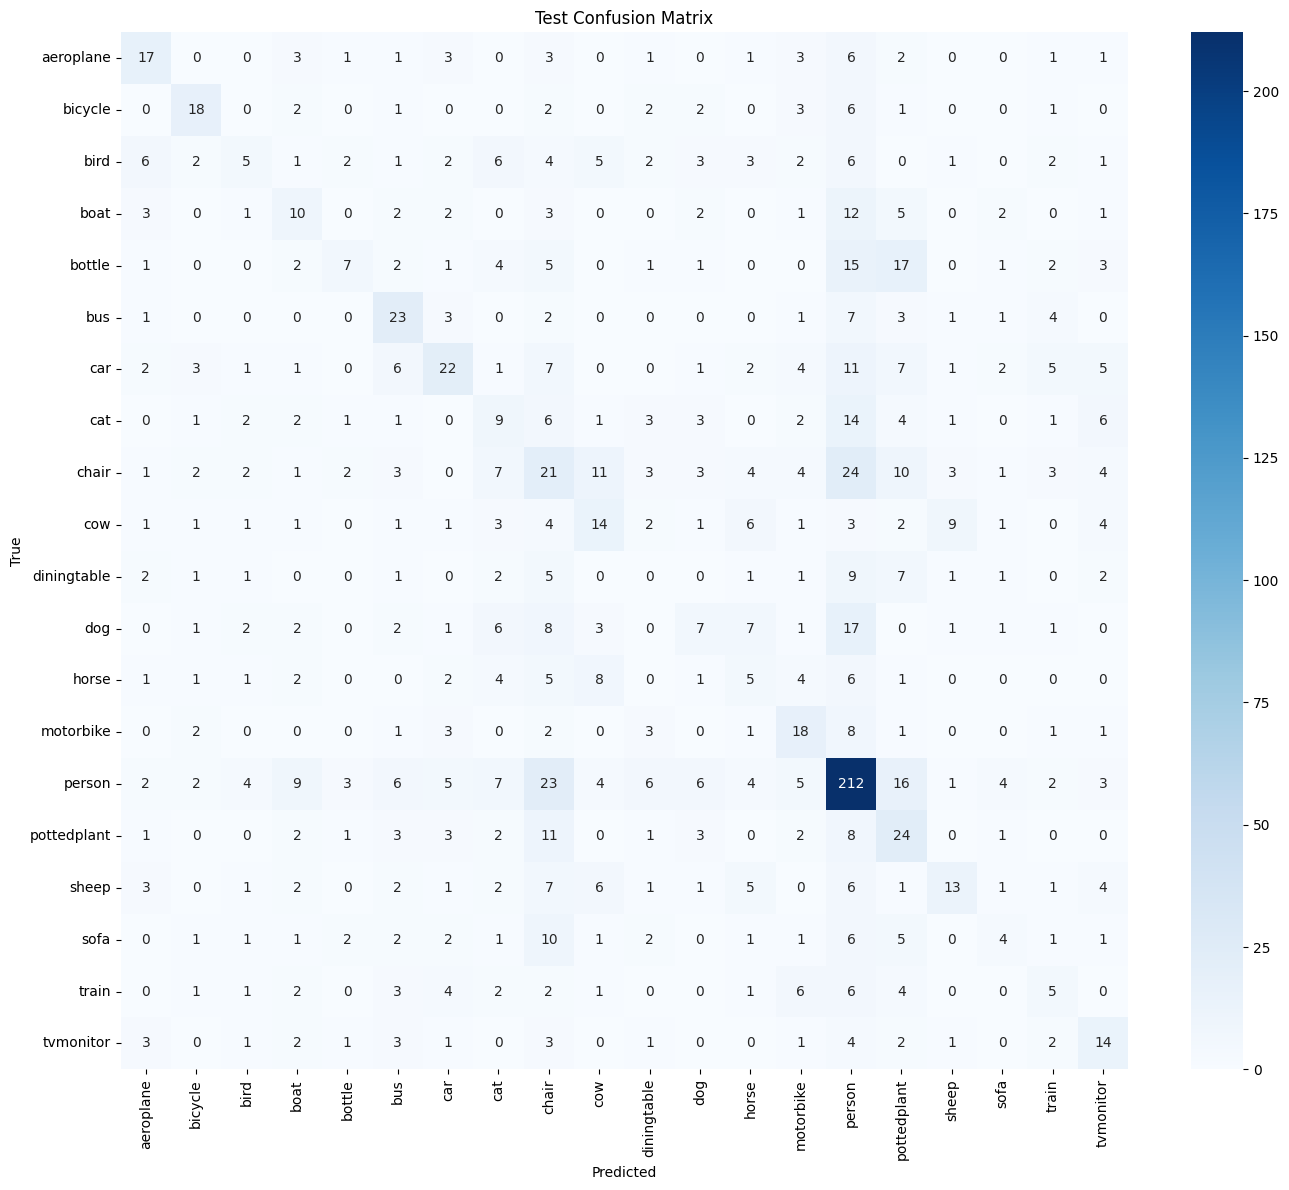

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


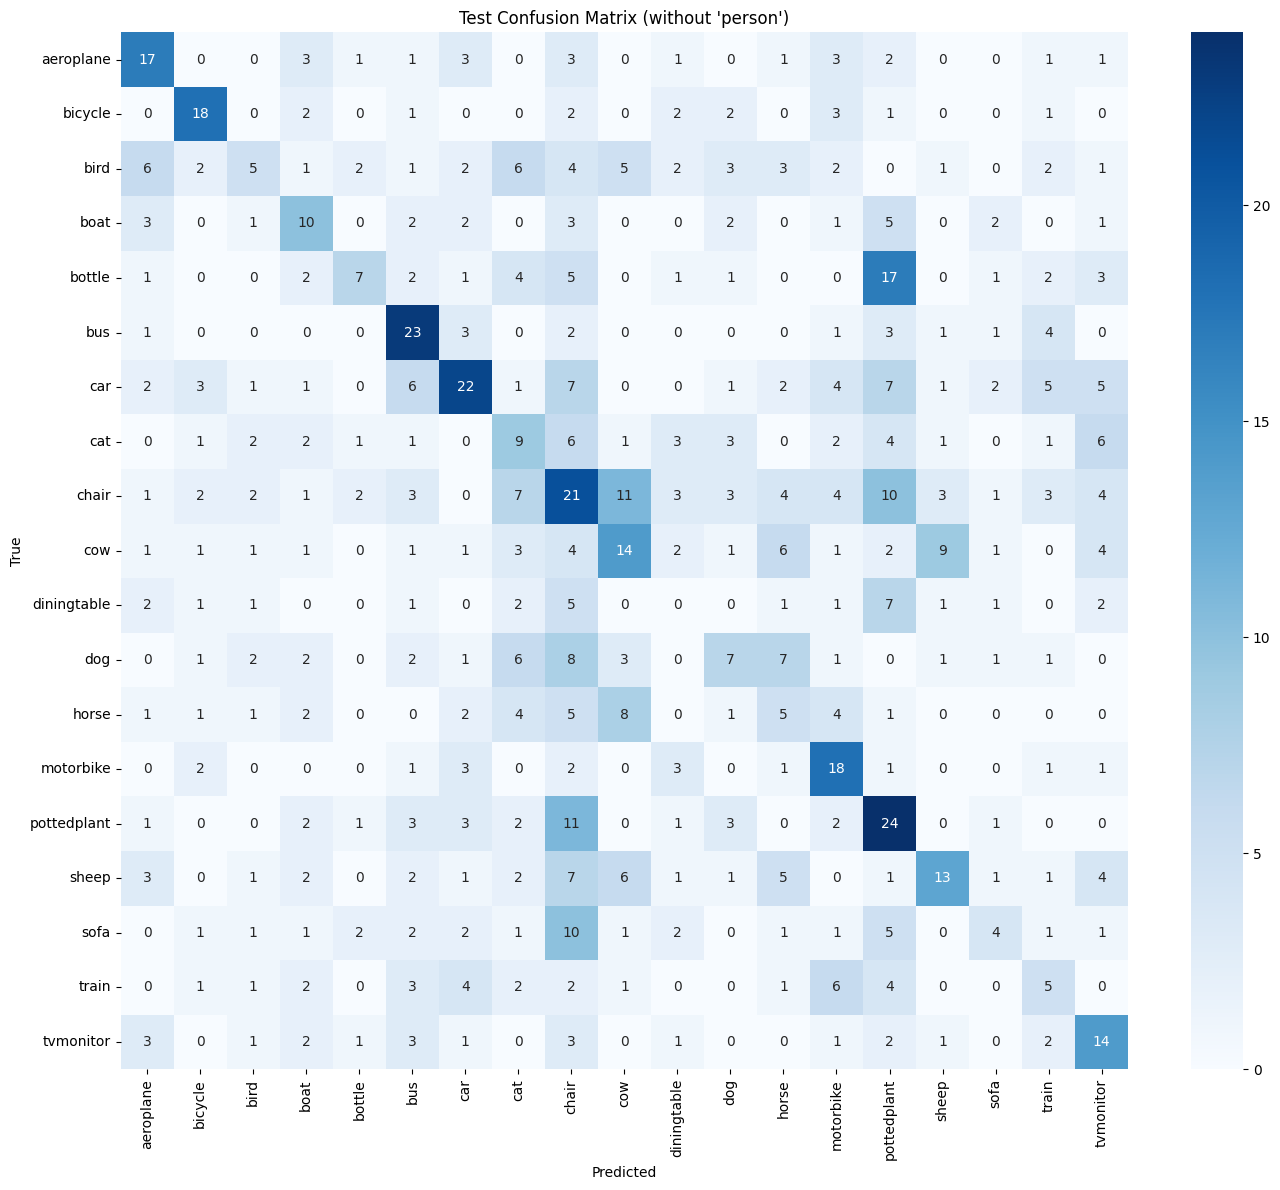

In [ ]:
person_idx = class_names.index('person')

cm_noperson = np.delete(cm, person_idx, axis=0)
cm_noperson = np.delete(cm_noperson, person_idx, axis=1)

class_names_noperson = [name for i, name in enumerate(class_names) if i != person_idx]

plt.figure(figsize=(14,12))
sns.heatmap(cm_noperson, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_noperson, yticklabels=class_names_noperson)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix (without 'person')")
plt.tight_layout()
plt.show()

In [18]:
dataset

Dataset ImageFolder
    Number of datapoints: 6638
    Root location: /content/drive/MyDrive/segmented_backup_deepLab_v3
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
labels = []

for i in range(len(dataset)):
    try:
        img, label = dataset[i]
        labels.append(label)
        if i % 100 == 0:
            print(f"Processed: {i}")
    except Exception as e:
        print(f"Error at index {i}: {e}")


Processed: 0
Processed: 100
Processed: 200
Processed: 300
Processed: 400
Processed: 500
Processed: 600
Processed: 700
Processed: 800
Processed: 900
Processed: 1000
Processed: 1100
Processed: 1200
Processed: 1300
Processed: 1400
Processed: 1500
Processed: 1600
Processed: 1700
Processed: 1800
Processed: 1900
Processed: 2000
Processed: 2100
Processed: 2200
Processed: 2300
Processed: 2400
Processed: 2500
Processed: 2600
Processed: 2700
Processed: 2800
Processed: 2900
Processed: 3000
Processed: 3100
Processed: 3200
Processed: 3300
Processed: 3400
Processed: 3500
Processed: 3600
Processed: 3700
Processed: 3800
Processed: 3900
Processed: 4000
Processed: 4100
Processed: 4200
Processed: 4300
Processed: 4400
Processed: 4500
Processed: 4600
Processed: 4700
Processed: 4800
Processed: 4900
Processed: 5000
Processed: 5100
Processed: 5200
Processed: 5300
Processed: 5400
Processed: 5500
Processed: 5600
Processed: 5700
Processed: 5800
Processed: 5900
Processed: 6000
Processed: 6100
Processed: 6200
Proc

In [21]:
from collections import Counter
import numpy as np

counts = Counter(labels)
class_names = dataset.classes
person_idx = class_names.index("person")


non_person_counts = [v for i, v in counts.items() if i != person_idx]
target_count = int(np.mean(non_person_counts))
print(f"Target count per class (mean): {target_count}")

Target count per class (mean): 264


In [22]:
import random

random.seed(42)
indices_per_class = {i: [] for i in range(len(class_names))}
for idx, (_, label) in enumerate(dataset):
    indices_per_class[label].append(idx)

person_idx = class_names.index("person")
non_person_counts = [len(idxs) for i, idxs in indices_per_class.items() if i != person_idx]
target_count = int(np.mean(non_person_counts))
print(f"Target count per class (mean, excluding person): {target_count}")


Target count per class (mean, excluding person): 264


In [25]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

balanced_indices = []
for i, idxs in indices_per_class.items():
    if i == person_idx:
        # Undersample 'person' class only
        chosen = random.sample(idxs, target_count)
    else:
        chosen = idxs  # Keep all samples
    balanced_indices.extend(chosen)

random.shuffle(balanced_indices)
print(f"Balanced dataset size: {len(balanced_indices)}")


counts_bal = Counter([dataset[idx][1] for idx in balanced_indices])

balanced_dataset = Subset(dataset, balanced_indices)
labels_bal = [dataset[idx][1] for idx in balanced_indices]
labels_bal = np.array(labels_bal)


train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    np.arange(len(labels_bal)), labels_bal,
    test_size=0.36, stratify=labels_bal, random_state=42
)


val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=20/36, stratify=temp_labels, random_state=42
)

Balanced dataset size: 5282


In [26]:
batch_size = 32
train_dataset = Subset(balanced_dataset, train_idx)
val_dataset   = Subset(balanced_dataset, val_idx)
test_dataset  = Subset(balanced_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [29]:
import torch.nn as nn

class SimpleCNN1(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 112x112x32
        x = self.pool(F.relu(self.conv2(x)))   # 56x56x64
        x = self.pool(F.relu(self.conv3(x)))   # 28x28x128
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
from itertools import product

param_grid = {
    "lr": [1e-4, 1e-3, 1e-2],
    "optimizer": ["adam", "sgd"],
    "batch_size": [32, 64],
}

search_space = list(product(param_grid["lr"], param_grid["optimizer"], param_grid["batch_size"]))


In [39]:
import copy
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

best_val_acc = 0
best_model = None
best_params = None
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr, opt_type, batch_size in search_space:
    print(f"\n🔍 Trying: lr={lr}, optimizer={opt_type}, batch_size={batch_size}")

    # Reinitialize model
    model = SimpleCNN1(num_classes=len(class_names)).to(device)

    # Optimizer
    if opt_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif opt_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Dataloaders
    train_loader_hp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_hp = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Train
    trained_model, history = train_model(
        model,
        train_loader_hp,
        val_loader_hp,
        optimizer,
        criterion,
        device,
        epochs=5,  # use fewer epochs for search
        scheduler=None,
        return_best=True,
        save_best_path=None,
        # verbose=False  # turn off if noisy
    )

    final_val_acc = history["val_acc"][-1]
    results.append((final_val_acc, lr, opt_type, batch_size))

    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_model = copy.deepcopy(trained_model)
        best_params = {"lr": lr, "optimizer": opt_type, "batch_size": batch_size}

print("\n✅ Best Config:")
print(best_params)
print(f"Best Val Accuracy: {best_val_acc:.4f}")



🔍 Trying: lr=0.0001, optimizer=adam, batch_size=32
Epoch 1/5 | Train Loss: 2.8157 Acc: 0.1571 | Val Loss: 2.6315 Acc: 0.2059
Epoch 2/5 | Train Loss: 2.3188 Acc: 0.3133 | Val Loss: 2.4071 Acc: 0.3101
Epoch 3/5 | Train Loss: 1.9138 Acc: 0.4388 | Val Loss: 2.2816 Acc: 0.3408
Epoch 4/5 | Train Loss: 1.5336 Acc: 0.5450 | Val Loss: 2.2749 Acc: 0.3491
Epoch 5/5 | Train Loss: 1.1710 Acc: 0.6710 | Val Loss: 2.3491 Acc: 0.3432

🔍 Trying: lr=0.0001, optimizer=adam, batch_size=64
Epoch 1/5 | Train Loss: 2.8362 Acc: 0.1527 | Val Loss: 2.6852 Acc: 0.1964
Epoch 2/5 | Train Loss: 2.3774 Acc: 0.2964 | Val Loss: 2.4690 Acc: 0.2757
Epoch 3/5 | Train Loss: 2.0200 Acc: 0.4068 | Val Loss: 2.3397 Acc: 0.3065
Epoch 4/5 | Train Loss: 1.7208 Acc: 0.4967 | Val Loss: 2.3129 Acc: 0.3396
Epoch 5/5 | Train Loss: 1.3360 Acc: 0.6183 | Val Loss: 2.4294 Acc: 0.3136

🔍 Trying: lr=0.0001, optimizer=sgd, batch_size=32
Epoch 1/5 | Train Loss: 2.9769 Acc: 0.0905 | Val Loss: 2.9610 Acc: 0.1041
Epoch 2/5 | Train Loss: 2.9523 

# SGD
## lr=0.001, optimizer=sgd, batch_size=32, epochs=20

In [40]:
import copy
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F


best_val_acc = 0
best_model = None
best_params = None
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN1(num_classes=len(class_names)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loader_hp = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_hp = DataLoader(val_dataset, batch_size=32, shuffle=False)

trained_model, history = train_model(
        model,
        train_loader_hp,
        val_loader_hp,
        optimizer,
        criterion,
        device,
        epochs=20,
        scheduler=None,
        return_best=True,
        save_best_path=None,
)

import json

with open("training_history.json", "w") as f:
    json.dump(history, f)

final_val_acc = history["val_acc"][-1]
print(f"Final Val Accuracy: {final_val_acc:.4f}")


Epoch 1/20 | Train Loss: 2.9506 Acc: 0.1036 | Val Loss: 2.9062 Acc: 0.1183
Epoch 2/20 | Train Loss: 2.8540 Acc: 0.1376 | Val Loss: 2.8058 Acc: 0.1574
Epoch 3/20 | Train Loss: 2.6972 Acc: 0.1967 | Val Loss: 2.7299 Acc: 0.1846
Epoch 4/20 | Train Loss: 2.5528 Acc: 0.2488 | Val Loss: 2.6134 Acc: 0.2130
Epoch 5/20 | Train Loss: 2.4239 Acc: 0.2870 | Val Loss: 2.5907 Acc: 0.2213
Epoch 6/20 | Train Loss: 2.2584 Acc: 0.3210 | Val Loss: 2.5289 Acc: 0.2592
Epoch 7/20 | Train Loss: 2.0942 Acc: 0.3763 | Val Loss: 2.4940 Acc: 0.2686
Epoch 8/20 | Train Loss: 1.9568 Acc: 0.4000 | Val Loss: 2.4917 Acc: 0.2639
Epoch 9/20 | Train Loss: 1.7713 Acc: 0.4595 | Val Loss: 2.4386 Acc: 0.2947
Epoch 10/20 | Train Loss: 1.5355 Acc: 0.5399 | Val Loss: 2.5696 Acc: 0.2840
Epoch 11/20 | Train Loss: 1.2765 Acc: 0.6225 | Val Loss: 2.6428 Acc: 0.2509
Epoch 12/20 | Train Loss: 1.0091 Acc: 0.7047 | Val Loss: 2.8309 Acc: 0.2840
Epoch 13/20 | Train Loss: 0.7492 Acc: 0.7820 | Val Loss: 3.0083 Acc: 0.2793
Epoch 14/20 | Train L

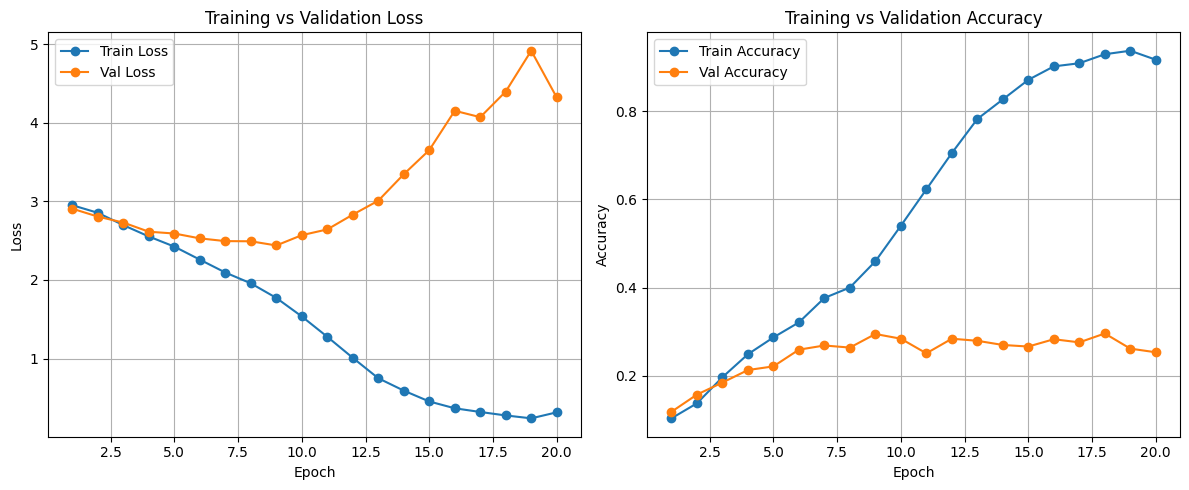

In [41]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(epochs, history["val_acc"], label="Val Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN1(num_classes=len(class_names)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    return_best=True,
    save_best_path="best_simplecnn_segmented_balanced.pth"
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 | Train Loss: 2.7940 Acc: 0.1636 | Val Loss: 2.5617 Acc: 0.2237


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10 | Train Loss: 2.2191 Acc: 0.3322 | Val Loss: 2.2903 Acc: 0.2994


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/10 | Train Loss: 1.6964 Acc: 0.4879 | Val Loss: 2.4176 Acc: 0.3077


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/10 | Train Loss: 1.1050 Acc: 0.6595 | Val Loss: 2.5393 Acc: 0.3219


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/10 | Train Loss: 0.5783 Acc: 0.8302 | Val Loss: 3.8458 Acc: 0.2805


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/10 | Train Loss: 0.3058 Acc: 0.9101 | Val Loss: 4.5673 Acc: 0.3006
Epoch 7/10 | Train Loss: 0.2583 Acc: 0.9257 | Val Loss: 5.1595 Acc: 0.2663


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/10 | Train Loss: 0.1992 Acc: 0.9423 | Val Loss: 5.1482 Acc: 0.2959


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/10 | Train Loss: 0.1830 Acc: 0.9473 | Val Loss: 5.9861 Acc: 0.2817


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/10 | Train Loss: 0.2134 Acc: 0.9373 | Val Loss: 5.4576 Acc: 0.2888


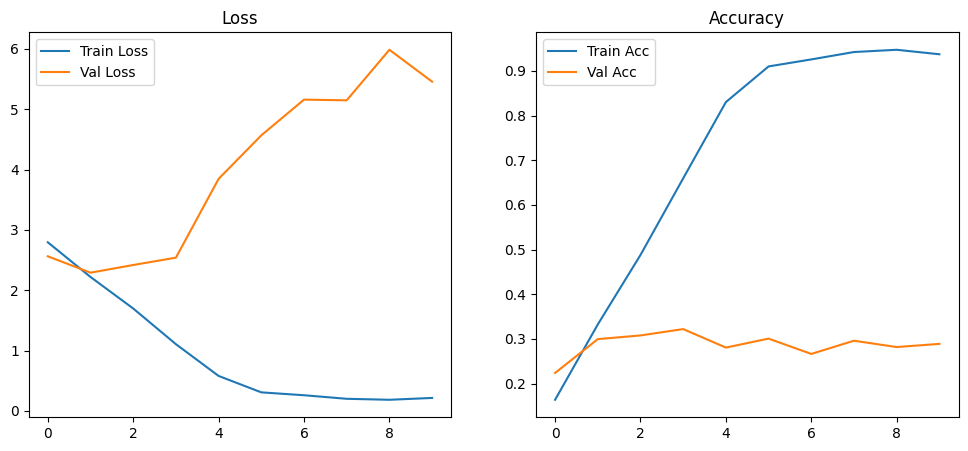

In [ ]:
plot_history(history)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy: 0.3491
              precision    recall  f1-score   support

   aeroplane       0.48      0.67      0.56        43
     bicycle       0.47      0.50      0.49        38
        bird       0.28      0.22      0.25        54
        boat       0.41      0.30      0.34        44
      bottle       0.36      0.32      0.34        62
         bus       0.75      0.46      0.57        46
         car       0.48      0.49      0.48        81
         cat       0.24      0.35      0.29        57
       chair       0.29      0.45      0.35       109
         cow       0.39      0.29      0.33        56
 diningtable       0.11      0.26      0.16        34
         dog       0.11      0.08      0.10        60
       horse       0.12      0.07      0.09        41
   motorbike       0.39      0.56      0.46        41
      person       0.23      0.09      0.13        53
 pottedplant       0.51      0.53      0.52        62
       sheep       0.36      0.39      0.37        57
     

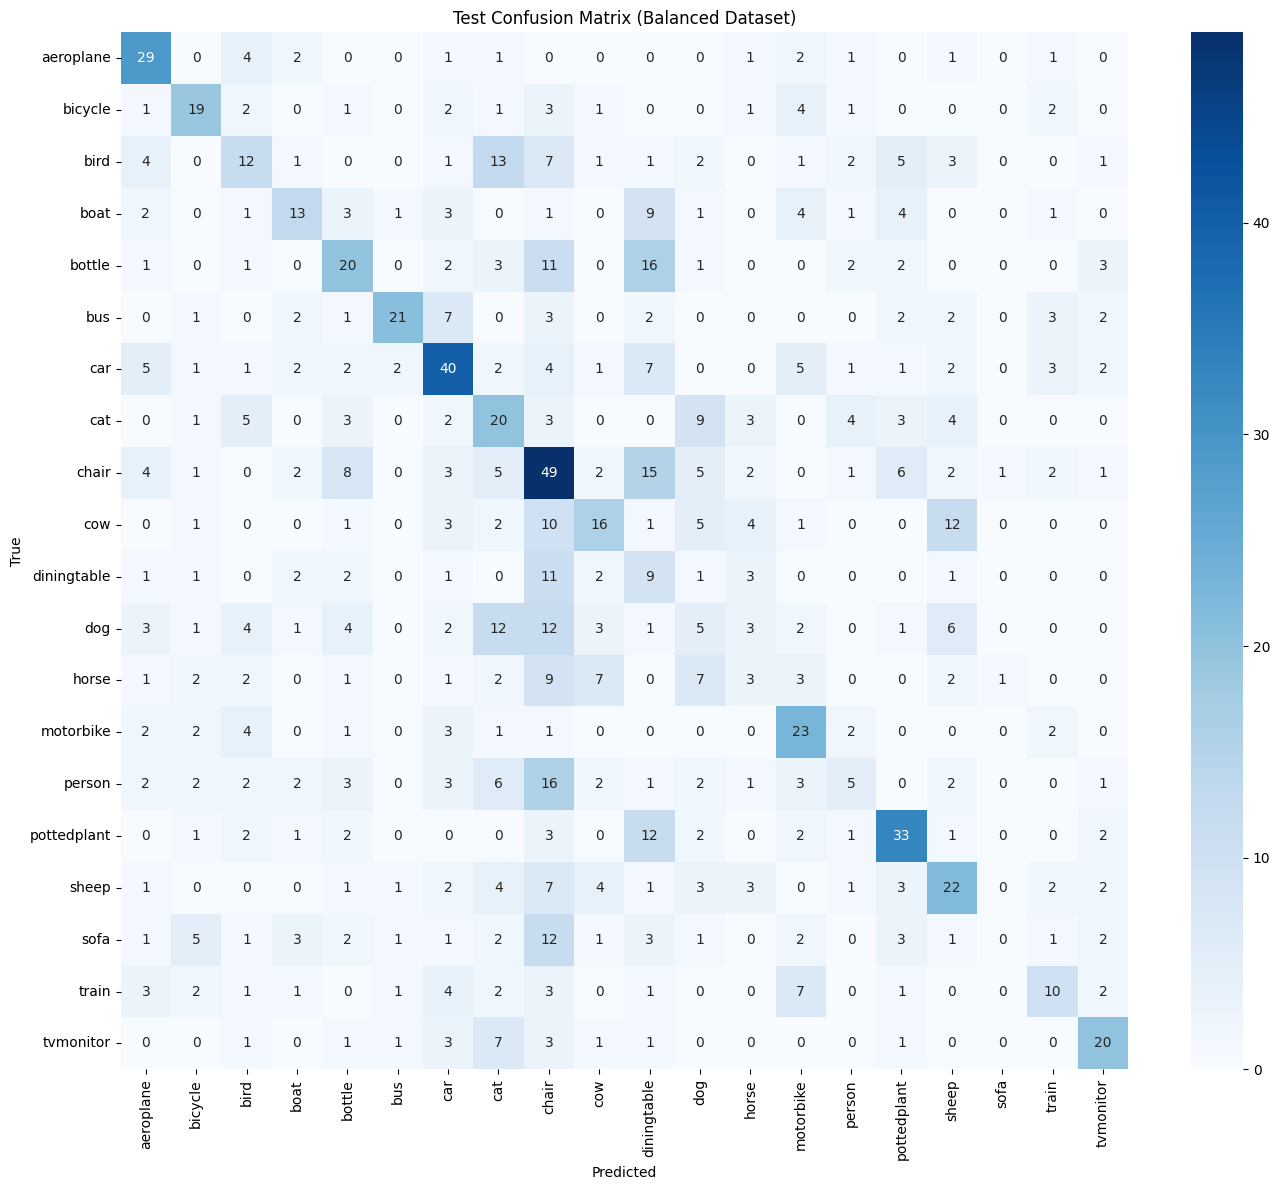

In [ ]:
model = SimpleCNN(num_classes=len(class_names))
model.load_state_dict(torch.load("best_simplecnn_segmented_balanced.pth", map_location=device))
model = model.to(device)
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 3. Print metrics
acc = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {acc:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix (Balanced Dataset)")
plt.tight_layout()
plt.show()
